# Курсовой проект МЕГАФОН

### Постановка задачи

 У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон»
предлагает обширный набор различных услуг своим абонентам. При этом разным
пользователям интересны разные услуги. Поэтому необходимо построить
алгоритм, который для каждой пары пользователь-услуга определит вероятность
подключения услуги.


##### Итого, в качестве входных данных будут представлены:
● data_train.csv: id, vas_id, buy_time, target
● features.csv.zip: id, <feature_list>

##### И тестовый набор:
● data_test.csv: id, vas_id, buy_time
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент
не подключил услугу соответственно.
buy_time - время покупки, представлено в формате timestamp, для работы с
этим столбцом понадобится функция datetime.fromtimestamp из модуля
datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для
работы с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться
библиотекой Dask

##### Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например
делает функция sklearn.metrics.f1_score(…, average=’macro’).
sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation

#### Формат представления результата
1. Работающая модель в формате pickle, которая принимает файл data_test.csv
из корневой папки и записывает в эту же папку файл answers_test.csv. В этом
файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно
записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука.
3. Презентация в формате .pdf, в которой необходимо отразить:
● Информация о модели, ее параметрах, особенностях и основных
результатах.
● Обоснование выбора модели и ее сравнение с альтернативами.
● Принцип составления индивидуальных предложений для выбранных
абонентов.
Рекомендуемое количество слайдов – 5 – 10.
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и
резюме необходимо прикрепить ко второму уроку “курсовой проект”.

In [208]:
import numpy as np
import datetime
import pandas as pd
import dask.dataframe as dd
from datetime import date
import matplotlib.pyplot as plt 

### Обзор данных

In [209]:
FEATURES_PATH = 'features.csv'
TRAIN_DF_PATH = 'data_train.csv'
users_data_df_PATH = 'data_test.csv'
DATA_TRAIN_FEATURES_PATH = 'data_train_features.csv'
DATA_TEST_FEATURES_PATH = 'data_test_features.csv'

In [210]:
features_df = dd.read_csv(FEATURES_PATH, sep="\t")
features_df = features_df.drop('Unnamed: 0', axis=1)
features_df.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [211]:
features_df.tail()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
12423,3521417,1548018000,-96.799971,-29.579112,-94.900786,-40.506798,-100.318246,-61.61179,-16.08618,-65.076097,...,1133.626154,1497.229208,-25.996269,-36.630448,-126.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
12424,3521563,1547413200,30.530029,-150.929112,16.589214,-34.046798,11.171754,-55.15179,-16.08618,-65.076097,...,-680.373846,-316.770792,-25.996269,-35.630448,-296.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
12425,3521574,1546808400,-96.799971,-396.439112,-110.740786,-447.776798,-116.158246,-468.88179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
12426,3521640,1547413200,38.030029,-152.519112,24.089214,-175.956798,18.671754,-197.06179,-16.08618,-65.076097,...,2242.626154,2528.229208,-25.996269,90.369552,-26.747724,-18.832889,-0.694428,-12.175933,0.54386,0.0
12427,3521702,1548018000,9.780029,-145.769112,-4.160786,-198.376798,-9.578246,-219.48179,-16.08618,-65.076097,...,-975.373846,-612.770792,-25.996269,-35.630448,-288.747724,-20.832889,-0.694428,-12.175933,-0.45614,0.0


In [212]:
train_df = pd.read_csv(TRAIN_DF_PATH)
train_df = train_df.drop('Unnamed: 0', axis=1) # отсеяны данные по отсутствующим абонентам

In [213]:
train_df = pd.read_csv(TRAIN_DF_PATH)
train_df = train_df.drop('Unnamed: 0', axis=1) # отсеяны данные по отсутстаующим абонентам

##### Переведём данные к удобному формату с помощью модуля datetime

In [214]:
train_df['date'] =  train_df['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [215]:
print(f"min: {train_df['date'].min()} | max: {train_df['date'].max()}")

min: 2018-07-09 | max: 2018-12-31


In [216]:
data_nole = train_df.loc[(train_df['target']==0, 'vas_id') ].value_counts().sort_index()
data_nole

1.0    304511
2.0    244708
4.0     63991
5.0     92393
6.0     33174
7.0     15219
8.0     13003
9.0      4468
Name: vas_id, dtype: int64

In [217]:
list(data_nole.index)

[1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [218]:
np.asarray(data_nole)

array([304511, 244708,  63991,  92393,  33174,  15219,  13003,   4468],
      dtype=int64)

In [219]:
data_one = train_df.loc[(train_df['target']==1, 'vas_id') ].value_counts().sort_index()
data_one

1.0     5664
2.0     4797
4.0    21765
5.0     1692
6.0    24704
7.0      213
8.0      347
9.0     1004
Name: vas_id, dtype: int64

In [220]:
np.asarray(data_one)

array([ 5664,  4797, 21765,  1692, 24704,   213,   347,  1004],
      dtype=int64)

vas_id-код услуги
0-отклонение предложения
1-принятие предложения

In [221]:
data_values = np.asarray(data_one)
data_values

array([ 5664,  4797, 21765,  1692, 24704,   213,   347,  1004],
      dtype=int64)

In [222]:
data_new = {'vas_id': list(data_nole.index), '0': list(np.asarray(data_nole)), '1': list(np.asarray(data_one))}
data_new

{'vas_id': [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
 '0': [304511, 244708, 63991, 92393, 33174, 15219, 13003, 4468],
 '1': [5664, 4797, 21765, 1692, 24704, 213, 347, 1004]}

In [223]:
data_new['vas_id'] = (list(data_nole.index))

In [224]:
data_new['0'] = (list(data_nole.values))

In [225]:
data_new['1'] = (list(data_one.values))

##### Объединение таблиц по id пользователей

In [226]:
pd.DataFrame(data_new)

,vas_id,0,1
0,1.0,304511,5664
1,2.0,244708,4797
2,4.0,63991,21765
3,5.0,92393,1692
4,6.0,33174,24704
5,7.0,15219,213
6,8.0,13003,347
7,9.0,4468,1004


##### Из таблицы видно,что наиболее популярны услуги 4 и 6.Их абсолютные значения выделяются на фоне остальных

In [227]:
train_df.tail()

,id,vas_id,buy_time,target,date
831648,3812226,2.0,1546203600,0.0,2018-12-31
831649,2480469,2.0,1546203600,0.0,2018-12-31
831650,158236,2.0,1546203600,0.0,2018-12-31
831651,1825525,2.0,1546203600,0.0,2018-12-31
831652,3022610,2.0,1546203600,0.0,2018-12-31


In [228]:
train_df.head()

,id,vas_id,buy_time,target,date
0,540968,8.0,1537131600,0.0,2018-09-17
1,1454121,4.0,1531688400,0.0,2018-07-16
2,2458816,1.0,1534107600,0.0,2018-08-13
3,3535012,5.0,1535922000,0.0,2018-09-03
4,1693214,1.0,1535922000,0.0,2018-09-03


In [229]:
train_df['id'].value_counts().sort_values(ascending=False)

17679      3
2072755    3
1532983    3
148271     3
1243361    3
          ..
2698463    1
2696414    1
2196004    1
738450     1
2101246    1
Name: id, Length: 806613, dtype: int64

##### Из сортировки видно,что некоторым пользователям делались предложения по 2-3 раза.

##### При этом,831652-806613=25039 пользователей не охвачены вниманием.

### Построение динамики предложений

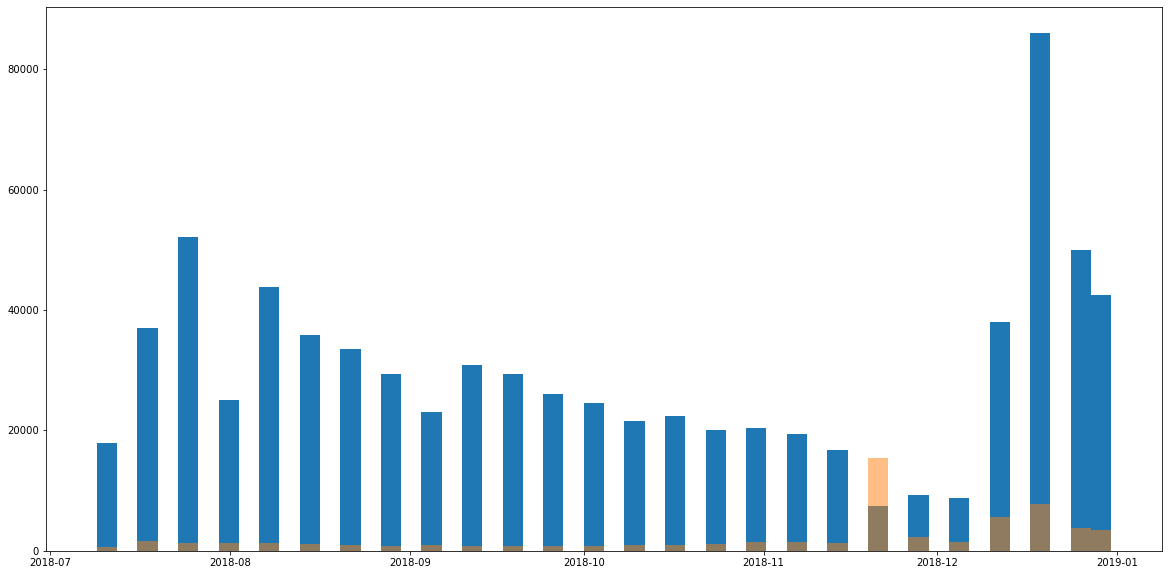

In [162]:
plt.figure(figsize=(20,10))
plt.hist(train_df.loc[(train_df['target']==0, 'date') ], bins=50, rwidth=5, stacked=False)
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.show()

##### Виден аномальный скачок предложений в конце ноября и перед новым годом(акционный период).

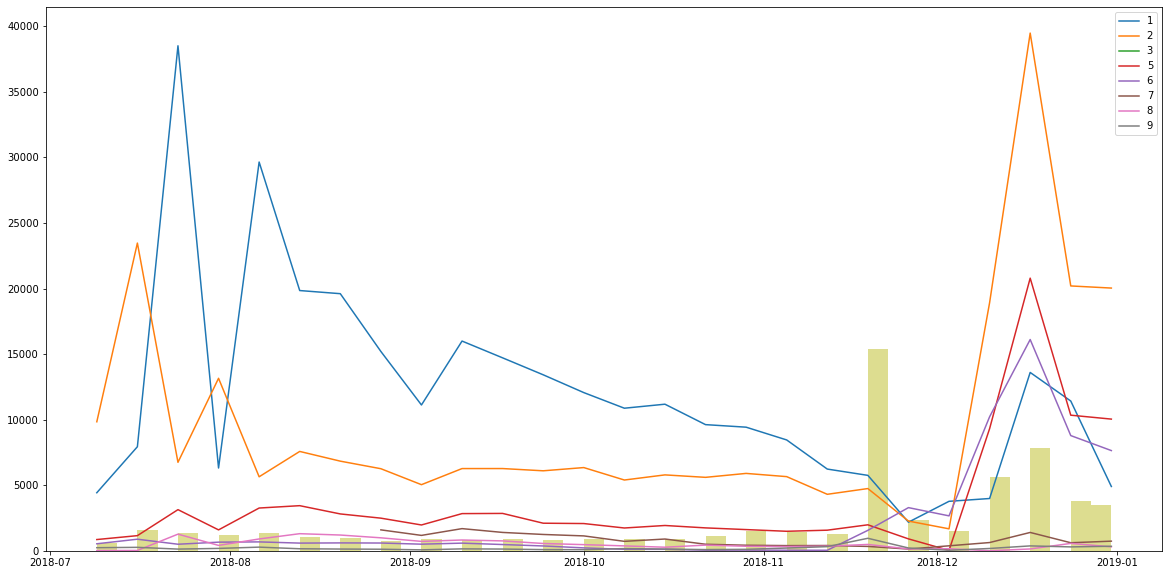

In [59]:
plt.figure(figsize=(20,10))
plt.plot(train_df.loc[(train_df['vas_id']==1.0, 'date') ].value_counts().sort_index(),label='1')
plt.plot(train_df.loc[(train_df['vas_id']==2.0, 'date') ].value_counts().sort_index(),label='2')
plt.plot(train_df.loc[(train_df['vas_id']==3.0, 'date') ].value_counts().sort_index(),label='3')
plt.plot(train_df.loc[(train_df['vas_id']==5.0, 'date') ].value_counts().sort_index(),label='5')
plt.plot(train_df.loc[(train_df['vas_id']==6.0, 'date') ].value_counts().sort_index(),label='6')
plt.plot(train_df.loc[(train_df['vas_id']==7.0, 'date') ].value_counts().sort_index(),label='7')
plt.plot(train_df.loc[(train_df['vas_id']==8.0, 'date') ].value_counts().sort_index(),label='8')
plt.plot(train_df.loc[(train_df['vas_id']==9.0, 'date') ].value_counts().sort_index(),label='9')
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.legend()
plt.show()

##### То же самое мы наблюдаем по графикам.Скачки предложений в конце ноября и перед новым годом.И два пика покупок.

##### Предложения в ноябре не оправдались,зато в декабре акция дала результат

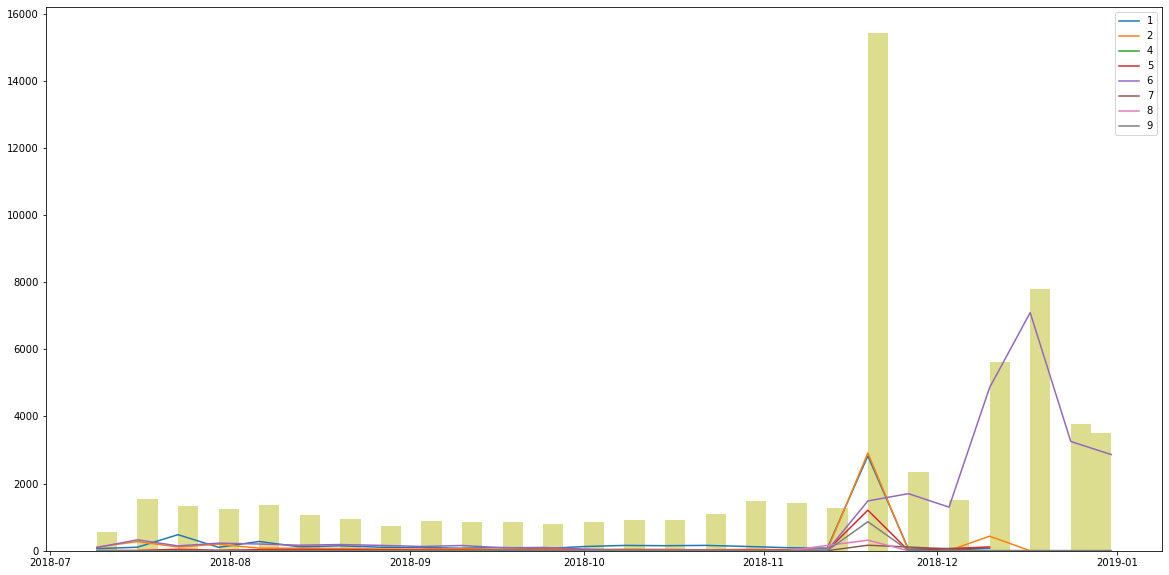

In [60]:
plt.figure(figsize=(20,10))
plt.plot(train_df.loc[((train_df['vas_id']==1.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='1')
plt.plot(train_df.loc[((train_df['vas_id']==2.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='2')
plt.plot(train_df.loc[((train_df['vas_id']==3.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='4')
plt.plot(train_df.loc[((train_df['vas_id']==5.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='5')
plt.plot(train_df.loc[((train_df['vas_id']==6.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='6')
plt.plot(train_df.loc[((train_df['vas_id']==7.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='7')
plt.plot(train_df.loc[((train_df['vas_id']==8.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='8')
plt.plot(train_df.loc[((train_df['vas_id']==9.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='9')
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.legend()
plt.show()

##### Здесь мы видим количество подключений услуг.В ноябре услуги 4 и 6 в лидерах,в декабре--услуга 6

In [230]:
train_df.loc[(train_df['target']==1, 'vas_id') ].value_counts().sort_index()

1.0     5664
2.0     4797
4.0    21765
5.0     1692
6.0    24704
7.0      213
8.0      347
9.0     1004
Name: vas_id, dtype: int64

In [231]:
dic = {'vas_id':[],
       '0':[],
       '1':[]
        }
vas_ids = np.sort(train_df['vas_id'].unique())

for vas_id in vas_ids:
    temp_df = train_df.loc[(train_df['vas_id']==vas_id)]
    c_0 = len(temp_df.loc[(temp_df['target']==0)])/len(temp_df['target'])
    c_1 = len(temp_df.loc[(temp_df['target']==1)])/len(temp_df['target'])
    dic['vas_id'].append(vas_id)
    dic['0'].append(f'{c_0:.3f}')
    dic['1'].append(f'{c_1:.3f}')
pd.DataFrame(dic)

,vas_id,0,1
0,1.0,0.982,0.018
1,2.0,0.981,0.019
2,4.0,0.746,0.254
3,5.0,0.982,0.018
4,6.0,0.573,0.427
5,7.0,0.986,0.014
6,8.0,0.974,0.026
7,9.0,0.817,0.183


##### Здесь та же таблица,только популярность услуг выражена в процентах.Всё синхронно--услуги 4 и 6 в лидерах

##### Удалим данные ноябрьского выброса,чтобы он нам не мешал

In [232]:
train_df = train_df[train_df['buy_time'] != int(datetime.datetime(2018,11,19,0,0).timestamp())]

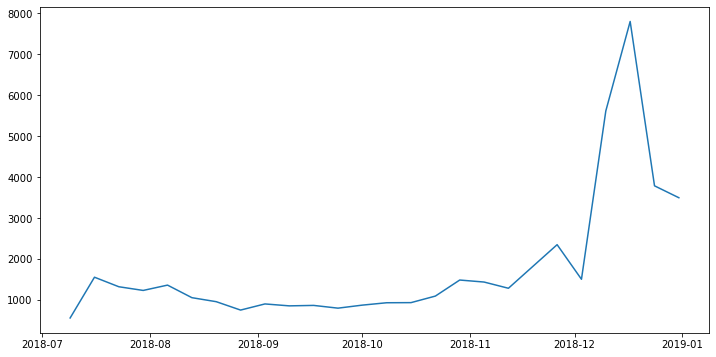

In [233]:
plt.figure(figsize=(12,6))
plt.plot(train_df.loc[(train_df['target']==1, 'date') ].value_counts().sort_index())

#### Объединение train_df c features_df

##### а)Удаляем из features_df записи по пользователям, которых нет в train_df.

In [234]:
user_ids = train_df['id'].unique()
features_df = features_df.compute()

features_df = features_df.loc[(features_df['id'].isin(user_ids))]

In [235]:
features_df.tail()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
12393,3513825,1546808400,-9.299971,-231.429112,26.779214,-183.566798,21.361754,-204.67179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
12394,3513869,1548018000,82.370029,-123.429112,155.939214,-88.526798,150.521754,-109.63179,-16.08618,-65.076097,...,-928.373846,-570.770792,-23.996269,-37.630448,-271.747724,-22.832889,-0.694428,-12.175933,-0.45614,0.0
12407,3517434,1548018000,-96.799971,-284.349112,-100.740786,-274.796798,-106.158246,-295.90179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
12415,3519714,1546808400,167.280029,110.140888,153.339214,57.533202,147.921754,36.42821,-2.00618,-50.996097,...,-977.373846,-613.770792,-14.996269,7.369552,-180.747724,-19.832889,0.305572,-12.175933,-0.45614,0.0
12421,3521152,1548018000,-96.799971,-198.259112,-110.740786,-250.866798,-116.158246,-263.72179,-16.08618,-65.076097,...,3312.626154,2447.229208,-22.996269,339.369552,17256.252276,-0.832889,0.305572,-12.175933,-0.45614,0.0


##### б)Объединение таблиц по id пользователей,учитываем тот факт, в таблице features_df должна иметься запись о пользователе с датой меньше либо равной записи в таблице train_df.

In [236]:
train_df = train_df.sort_index()
train_df = train_df.sort_values(by="buy_time")
features_df = features_df.sort_values(by="buy_time")

In [237]:
train_df.tail()

,id,vas_id,buy_time,target,date
647978,4040850,2.0,1546203600,0.0,2018-12-31
647972,4167221,6.0,1546203600,1.0,2018-12-31
647965,2257941,1.0,1546203600,0.0,2018-12-31
125578,2004081,2.0,1546203600,0.0,2018-12-31
831652,3022610,2.0,1546203600,0.0,2018-12-31


In [238]:
train_df.shape

(808738, 5)

In [239]:
features_df.shape

(822407, 255)

In [240]:
data_train = pd.merge_asof(train_df, features_df, on='buy_time', by='id')

In [241]:
data_train.shape

(808738, 258)

##### Количество строк  в train_df.shape и data_train.shape совпадают

#####  Проверка на nan значения

In [242]:
data_train.isnull().any()

id          False
vas_id      False
buy_time    False
target      False
date        False
            ...  
248          True
249          True
250          True
251          True
252          True
Length: 258, dtype: bool

##### в)Добавление новых столбцов в таблицу (День, месяц и номер недели).

In [243]:
data_train['week_on_month'] = data_train['date'].apply(lambda x: pd.to_datetime(x).day//7)
data_train['day'] = data_train['date'].apply(lambda x: pd.to_datetime(x).day)
data_train['month'] = data_train['date'].apply(lambda x: pd.to_datetime(x).month)
# data_train['year'] = data_train['date'].apply(lambda x: pd.to_datetime(x).year)
data_train = data_train.drop('date', axis=1)
data_train = data_train.drop('buy_time', axis=1)

In [33]:
features_df.loc[(features_df['id']==1510201)]

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
6980,1510201,1541970000,349.350029,1289.570888,377.779214,1524.253202,372.361754,1503.14821,365.26382,316.273903,...,657.626154,962.229208,111.003731,199.369552,-156.747724,-6.832889,13.305572,-12.175933,-0.45614,0.0


In [78]:
train_df.loc[(train_df['id']==1510201)]

,id,vas_id,buy_time,target,date
449997,1510201,6.0,1544389200,1.0,2018-12-10
449996,1510201,4.0,1544994000,0.0,2018-12-17
449998,1510201,6.0,1544994000,1.0,2018-12-17


In [244]:
data_train.loc[(data_train['target']==1, 'vas_id') ].value_counts().sort_index()

1.0     2840
2.0     1884
4.0    16125
5.0      482
6.0    23220
7.0       47
8.0       31
9.0      139
Name: vas_id, dtype: int64

##### Тип признака vas_id отнесён к целым числам

In [245]:
data_train.to_csv(DATA_TRAIN_FEATURES_PATH, index=False)

#### Выполним вышеуказанные операции для тестовой выборки

In [185]:
test_df = pd.read_csv(users_data_df_PATH)
test_df = test_df.drop('Unnamed: 0', axis=1)

##### Переведём данные к удобному формату с помощью модуля datetime¶

In [186]:
test_df['date'] =  test_df['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [187]:
print(f"min: {test_df['date'].min()} | max: {test_df['date'].max()}")

min: 2019-01-07 | max: 2019-01-21


In [188]:
test_df.head()

,id,vas_id,buy_time,date
0,3130519,2.0,1548018000,2019-01-21
1,2000860,4.0,1548018000,2019-01-21
2,1099444,2.0,1546808400,2019-01-07
3,1343255,5.0,1547413200,2019-01-14
4,1277040,2.0,1546808400,2019-01-07


In [189]:
test_df.tail()

,id,vas_id,buy_time,date
71226,2502453,5.0,1548018000,2019-01-21
71227,1693213,2.0,1548018000,2019-01-21
71228,1891350,2.0,1548018000,2019-01-21
71229,2437172,2.0,1548018000,2019-01-21
71230,988236,2.0,1548018000,2019-01-21


In [190]:
test_df['id'].value_counts().sort_values(ascending=False)

904411     3
409367     3
898205     3
1891312    3
44545      3
          ..
1210480    1
4218995    1
2658349    1
3975210    1
3278847    1
Name: id, Length: 70152, dtype: int64

##### Из сортировки видно,что некоторым пользователям делались предложения по 2-3 раза.¶

#### Объединение test_df c features_df

##### а)Удаляем из features_df записи по пользователям, которых нет в test_df.¶

In [194]:
user_ids_test = test_df['id'].unique()


features_df = features_df.loc[(features_df['id'].isin(user_ids_test))]
features_df.tail()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
778,3441297,1548018000,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
12661,4698,1548018000,-93.799971,-337.249112,-107.740786,-360.686798,-113.158246,-381.79179,-16.08618,-65.076097,...,934.626154,-611.770792,-25.996269,3571.369552,-120.747724,25.167111,-0.694428,-12.175933,-0.45614,1.0
1064,656122,1548018000,-32.219971,-145.469112,51.179214,-72.766798,45.761754,-93.87179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
5253,50923,1548018000,69.860029,-4.019112,83.429214,-3.786798,78.011754,-24.89179,-16.08618,-65.076097,...,-961.373846,-613.770792,-24.996269,-37.630448,-242.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
6591,987518,1548018000,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


##### б)Объединение таблиц по id пользователей,учитываем тот факт, в таблице features_df должна иметься запись о пользователе с датой меньше либо равной записи в таблице test_df.¶

In [196]:
test_df = test_df.sort_index()
test_df = test_df.sort_values(by="buy_time")
features_df = features_df.sort_values(by="buy_time")

In [197]:
test_df.shape

(71231, 4)

In [198]:
features_df.shape

(3817, 255)

In [199]:
data_test = pd.merge_asof(test_df, features_df, on='buy_time', by='id')

In [200]:
data_test.isnull().any()

id          False
vas_id      False
buy_time    False
date        False
0            True
            ...  
248          True
249          True
250          True
251          True
252          True
Length: 257, dtype: bool

In [204]:
data_test.loc[data_test['vas_id']].value_counts().sort_index()

id       vas_id  buy_time    date        0           1            2           3          4           5         6          7           8         9           10         11         12         13          14         15         16         17         18        19         20          21          22         23         24         25         26        27        28        29        30        31         32         33        34        35         36         37           38           39           40           41          42           43           44          45          46         47         48          49          50        51         52          53         54         55         56         57         58          59         60         61         62         63         64         65         66         67         68         69         70         71         72        73         74         75   76         77          78       79         80         81   82         83         84         85   86         87  

##### Тип признака vas_id отнесён к целым числам

##### в)Добавление новых столбцов в таблицу (День, месяц и номер недели).

In [205]:
data_test['week_on_month'] = data_test['date'].apply(lambda x: pd.to_datetime(x).day//7)
data_test['day'] = data_test['date'].apply(lambda x: pd.to_datetime(x).day)
data_test['month'] = data_test['date'].apply(lambda x: pd.to_datetime(x).month)

data_test = data_test.drop('date', axis=1)
data_test = data_test.drop('buy_time', axis=1)

In [206]:
features_df.loc[(features_df['id']==1510201)]

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252


In [207]:
data_test.to_csv(DATA_TEST_FEATURES_PATH, index=False)